## Creating a Stochastic Model Benchmark

In [15]:
import pandas as pd  
import numpy as np
from scipy.stats import t, rankdata
from copulae import StudentCopula
import matplotlib.pyplot as plt
from dotenv.main import load_dotenv
from tqdm import tqdm
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

load_dotenv(override=True)

True

In [16]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

In [17]:
parent_dir

'c:\\Users\\nicka\\master-thesis'

In [ ]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,3,4,5,6] 
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [19]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

In [20]:
entire_df = pd.concat([returns_df, test_returns_df])

test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

# Creating Testing Data

In [21]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]
    
    # Get returns and EONIA for this window
    window_returns = (window_data * weights).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]
    
    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return
    
    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()
    
    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0
    
    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_delta_bof_values_1.append(delta_bof)

## Concatonating all Stochastic Models

Plan
1. Same GBM with jumps model for all assets
2. Special Model for EONIA
3. Use some Copula --> Use Student-t Copula

In [22]:
#from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from internal_models.montecarlo.hybrid_mc import MonteCarloJumpGBM
from internal_models.montecarlo.test import OptimizedMonteCarloJumpGBM
from utilities.bof_var_plot import plot_bof_var

Uncomment if you want to test some stuff

In [23]:
'''
mc = MonteCarloJumpGBM(returns_df, weights)
bof_change, scr, simulated_results = mc.calculate_distribution_and_scr()
plot_bof_var(bof_change, scr, title="sad")

days = np.arange(252)

asset = 'EONIA' 

# Plot each simulation
plt.figure(figsize=(10, 6))
for i in range(len(simulated_results)):
    plt.plot(days, simulated_results[i][asset], alpha=0.7)
    break

plt.title('Price Path of ' + asset + ' Asset Across All Simulations')
plt.xlabel('Trading Days')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()
'''


'\nmc = MonteCarloJumpGBM(returns_df, weights)\nbof_change, scr, simulated_results = mc.calculate_distribution_and_scr()\nplot_bof_var(bof_change, scr, title="sad")\n\ndays = np.arange(252)\n\nasset = \'EONIA\' \n\n# Plot each simulation\nplt.figure(figsize=(10, 6))\nfor i in range(len(simulated_results)):\n    plt.plot(days, simulated_results[i][asset], alpha=0.7)\n    break\n\nplt.title(\'Price Path of \' + asset + \' Asset Across All Simulations\')\nplt.xlabel(\'Trading Days\')\nplt.ylabel(\'Price\')\nplt.grid(True, alpha=0.3)\nplt.show()\n'

## Generating all test SCRs

In [24]:
entire_df = pd.concat([returns_df, test_returns_df])

In [ ]:
scenarios_results = {}
portfolio_scr_results = {} 
lookback = 252 + 30

i = 0
for i, t in enumerate(tqdm(test_returns_df.index, desc='Processing Dates', unit='Date')):
    t_position = historical_df.index.get_loc(t)
    i += 1

    window_data = historical_df.iloc[t_position-lookback:t_position]
    mc_model = MonteCarloJumpGBM(window_data, weights)
    _, scr, _ = mc_model.calculate_distribution_and_scr()

    if t != test_returns_df.index[-1]:
        next_day = test_returns_df.index[test_returns_df.index.get_loc(t) + 1]
    else:
        print(f"Warning: {t} is the last day in the index, no next day available.")
        continue
    
    if scr > 0: scr = 0.0
    
    portfolio_scr_results[next_day] = scr

Processing Dates:   0%|          | 0/100 [00:00<?, ?Date/s]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   1%|          | 1/100 [00:14<23:10, 14.05s/Date]

Completed 10000 simulations in 13.85 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   2%|▏         | 2/100 [00:28<23:28, 14.37s/Date]

Completed 10000 simulations in 14.41 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   3%|▎         | 3/100 [00:43<23:35, 14.59s/Date]

Completed 10000 simulations in 14.67 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.68batch/s]


Completed 10000 simulations in 15.18 seconds


Processing Dates:   4%|▍         | 4/100 [00:58<23:50, 14.90s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.92batch/s]


Completed 10000 simulations in 14.35 seconds


Processing Dates:   5%|▌         | 5/100 [01:13<23:23, 14.77s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   6%|▌         | 6/100 [01:28<23:13, 14.83s/Date]

Completed 10000 simulations in 14.76 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.78batch/s]


Completed 10000 simulations in 14.80 seconds


Processing Dates:   7%|▋         | 7/100 [01:43<23:10, 14.95s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   8%|▊         | 8/100 [01:58<22:57, 14.97s/Date]

Completed 10000 simulations in 14.83 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:   9%|▉         | 9/100 [02:13<22:40, 14.95s/Date]

Completed 10000 simulations in 14.72 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  10%|█         | 10/100 [02:28<22:21, 14.91s/Date]

Completed 10000 simulations in 14.62 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  11%|█         | 11/100 [02:43<22:12, 14.97s/Date]

Completed 10000 simulations in 14.94 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.89batch/s]


Completed 10000 simulations in 14.44 seconds


Processing Dates:  12%|█▏        | 12/100 [02:58<21:54, 14.93s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  13%|█▎        | 13/100 [03:13<21:35, 14.90s/Date]

Completed 10000 simulations in 14.62 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  14%|█▍        | 14/100 [03:28<21:23, 14.93s/Date]

Completed 10000 simulations in 14.82 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.92batch/s]


Completed 10000 simulations in 14.47 seconds


Processing Dates:  15%|█▌        | 15/100 [03:42<21:01, 14.84s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  16%|█▌        | 16/100 [03:57<20:43, 14.80s/Date]

Completed 10000 simulations in 14.52 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.93batch/s]


Completed 10000 simulations in 14.45 seconds


Processing Dates:  17%|█▋        | 17/100 [04:12<20:29, 14.82s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  18%|█▊        | 18/100 [04:26<20:09, 14.75s/Date]

Completed 10000 simulations in 14.42 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.80batch/s]


Completed 10000 simulations in 14.68 seconds


Processing Dates:  19%|█▉        | 19/100 [04:41<19:57, 14.79s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.89batch/s]


Completed 10000 simulations in 14.54 seconds


Processing Dates:  20%|██        | 20/100 [04:56<19:41, 14.77s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  21%|██        | 21/100 [05:11<19:29, 14.80s/Date]

Completed 10000 simulations in 14.70 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.83batch/s]


Completed 10000 simulations in 14.67 seconds


Processing Dates:  22%|██▏       | 22/100 [05:26<19:21, 14.89s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  23%|██▎       | 23/100 [05:41<19:05, 14.88s/Date]

Completed 10000 simulations in 14.65 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  24%|██▍       | 24/100 [05:56<18:59, 14.99s/Date]

Completed 10000 simulations in 15.06 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  25%|██▌       | 25/100 [06:11<18:43, 14.98s/Date]

Completed 10000 simulations in 14.78 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  26%|██▌       | 26/100 [06:27<18:43, 15.19s/Date]

Completed 10000 simulations in 15.49 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.86batch/s]


Completed 10000 simulations in 14.52 seconds


Processing Dates:  27%|██▋       | 27/100 [06:42<18:23, 15.12s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  28%|██▊       | 28/100 [06:57<18:08, 15.12s/Date]

Completed 10000 simulations in 14.93 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  29%|██▉       | 29/100 [07:12<18:05, 15.28s/Date]

Completed 10000 simulations in 15.47 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  30%|███       | 30/100 [07:33<19:46, 16.95s/Date]

Completed 10000 simulations in 20.66 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  31%|███       | 31/100 [07:49<19:01, 16.54s/Date]

Completed 10000 simulations in 15.39 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.51batch/s]


Completed 10000 simulations in 15.88 seconds


Processing Dates:  32%|███▏      | 32/100 [08:05<18:40, 16.47s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  33%|███▎      | 33/100 [08:20<18:00, 16.12s/Date]

Completed 10000 simulations in 15.11 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.57batch/s]


Completed 10000 simulations in 15.66 seconds


Processing Dates:  34%|███▍      | 34/100 [08:36<17:38, 16.04s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  35%|███▌      | 35/100 [08:52<17:18, 15.97s/Date]

Completed 10000 simulations in 15.62 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  36%|███▌      | 36/100 [09:10<17:30, 16.41s/Date]

Completed 10000 simulations in 17.23 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.19batch/s]


Completed 10000 simulations in 16.86 seconds


Processing Dates:  37%|███▋      | 37/100 [09:27<17:27, 16.62s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.32batch/s]


Completed 10000 simulations in 16.51 seconds


Processing Dates:  38%|███▊      | 38/100 [09:43<17:12, 16.65s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.12batch/s]


Completed 10000 simulations in 17.15 seconds


Processing Dates:  39%|███▉      | 39/100 [10:01<17:08, 16.85s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  40%|████      | 40/100 [10:18<16:59, 16.99s/Date]

Completed 10000 simulations in 17.11 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.38batch/s]


Completed 10000 simulations in 16.21 seconds


Processing Dates:  41%|████      | 41/100 [10:34<16:32, 16.82s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.45batch/s]


Completed 10000 simulations in 15.99 seconds


Processing Dates:  42%|████▏     | 42/100 [10:51<16:04, 16.63s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  43%|████▎     | 43/100 [11:08<15:53, 16.72s/Date]

Completed 10000 simulations in 16.74 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.64batch/s]


Completed 10000 simulations in 15.36 seconds


Processing Dates:  44%|████▍     | 44/100 [11:23<15:20, 16.44s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  45%|████▌     | 45/100 [11:39<14:49, 16.18s/Date]

Completed 10000 simulations in 15.38 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.30batch/s]


Completed 10000 simulations in 16.52 seconds


Processing Dates:  46%|████▌     | 46/100 [11:56<14:42, 16.34s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  47%|████▋     | 47/100 [12:12<14:18, 16.20s/Date]

Completed 10000 simulations in 15.68 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.54batch/s]


Completed 10000 simulations in 15.63 seconds


Processing Dates:  48%|████▊     | 48/100 [12:27<13:56, 16.09s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.21batch/s]


Completed 10000 simulations in 16.79 seconds


Processing Dates:  49%|████▉     | 49/100 [12:45<13:57, 16.43s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  50%|█████     | 50/100 [13:01<13:36, 16.32s/Date]

Completed 10000 simulations in 15.89 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  51%|█████     | 51/100 [13:17<13:14, 16.21s/Date]

Completed 10000 simulations in 15.76 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  52%|█████▏    | 52/100 [13:32<12:45, 15.96s/Date]

Completed 10000 simulations in 15.18 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  53%|█████▎    | 53/100 [13:48<12:29, 15.96s/Date]

Completed 10000 simulations in 15.76 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.51batch/s]


Completed 10000 simulations in 15.71 seconds


Processing Dates:  54%|█████▍    | 54/100 [14:04<12:18, 16.05s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.58batch/s]


Completed 10000 simulations in 15.58 seconds


Processing Dates:  55%|█████▌    | 55/100 [14:20<11:58, 15.97s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:15<00:00,  4.31batch/s]


Completed 10000 simulations in 16.46 seconds


Processing Dates:  56%|█████▌    | 56/100 [14:37<11:51, 16.18s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  57%|█████▋    | 57/100 [14:52<11:21, 15.85s/Date]

Completed 10000 simulations in 14.87 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  58%|█████▊    | 58/100 [15:08<11:08, 15.92s/Date]

Completed 10000 simulations in 15.88 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.80batch/s]


Completed 10000 simulations in 14.71 seconds


Processing Dates:  59%|█████▉    | 59/100 [15:23<10:42, 15.68s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  60%|██████    | 60/100 [15:39<10:35, 15.88s/Date]

Completed 10000 simulations in 16.18 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.68batch/s]


Completed 10000 simulations in 15.04 seconds


Processing Dates:  61%|██████    | 61/100 [15:55<10:12, 15.69s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.78batch/s]


Completed 10000 simulations in 15.10 seconds


Processing Dates:  62%|██████▏   | 62/100 [16:10<09:52, 15.59s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  63%|██████▎   | 63/100 [16:25<09:28, 15.37s/Date]

Completed 10000 simulations in 14.68 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.87batch/s]


Completed 10000 simulations in 14.67 seconds


Processing Dates:  64%|██████▍   | 64/100 [16:40<09:10, 15.29s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  65%|██████▌   | 65/100 [16:55<08:56, 15.34s/Date]

Completed 10000 simulations in 15.26 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  66%|██████▌   | 66/100 [17:11<08:43, 15.39s/Date]

Completed 10000 simulations in 15.31 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  67%|██████▋   | 67/100 [17:26<08:24, 15.29s/Date]

Completed 10000 simulations in 14.90 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  68%|██████▊   | 68/100 [17:41<08:08, 15.28s/Date]

Completed 10000 simulations in 15.06 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.83batch/s]


Completed 10000 simulations in 14.64 seconds


Processing Dates:  69%|██████▉   | 69/100 [17:56<07:49, 15.14s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  70%|███████   | 70/100 [18:12<07:41, 15.37s/Date]

Completed 10000 simulations in 15.71 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  71%|███████   | 71/100 [18:27<07:23, 15.28s/Date]

Completed 10000 simulations in 14.89 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.84batch/s]


Completed 10000 simulations in 14.62 seconds


Processing Dates:  72%|███████▏  | 72/100 [18:42<07:05, 15.21s/Date]

Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.55batch/s]


Completed 10000 simulations in 15.59 seconds


Processing Dates:  73%|███████▎  | 73/100 [18:58<06:57, 15.46s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  74%|███████▍  | 74/100 [19:13<06:39, 15.38s/Date]

Completed 10000 simulations in 14.99 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  75%|███████▌  | 75/100 [19:28<06:18, 15.12s/Date]

Completed 10000 simulations in 14.34 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.83batch/s]


Completed 10000 simulations in 14.55 seconds


Processing Dates:  76%|███████▌  | 76/100 [19:42<06:00, 15.01s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  77%|███████▋  | 77/100 [19:58<05:50, 15.25s/Date]

Completed 10000 simulations in 15.63 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  78%|███████▊  | 78/100 [20:14<05:39, 15.45s/Date]

Completed 10000 simulations in 15.74 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  79%|███████▉  | 79/100 [20:29<05:23, 15.40s/Date]

Completed 10000 simulations in 15.11 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:14<00:00,  4.43batch/s]


Completed 10000 simulations in 16.03 seconds


Processing Dates:  80%|████████  | 80/100 [20:46<05:13, 15.66s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  81%|████████  | 81/100 [21:02<04:59, 15.74s/Date]

Completed 10000 simulations in 15.73 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  82%|████████▏ | 82/100 [21:18<04:46, 15.90s/Date]

Completed 10000 simulations in 16.08 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.78batch/s]


Completed 10000 simulations in 14.75 seconds


Processing Dates:  83%|████████▎ | 83/100 [21:33<04:26, 15.68s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  84%|████████▍ | 84/100 [21:48<04:06, 15.40s/Date]

Completed 10000 simulations in 14.57 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  85%|████████▌ | 85/100 [22:03<03:49, 15.30s/Date]

Completed 10000 simulations in 14.86 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  86%|████████▌ | 86/100 [22:18<03:34, 15.33s/Date]

Completed 10000 simulations in 15.20 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  87%|████████▋ | 87/100 [22:33<03:18, 15.24s/Date]

Completed 10000 simulations in 14.86 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.96batch/s]


Completed 10000 simulations in 14.35 seconds


Processing Dates:  88%|████████▊ | 88/100 [22:48<03:01, 15.11s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  89%|████████▉ | 89/100 [23:03<02:45, 15.05s/Date]

Completed 10000 simulations in 14.73 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  90%|█████████ | 90/100 [23:18<02:29, 14.90s/Date]

Completed 10000 simulations in 14.39 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  91%|█████████ | 91/100 [23:32<02:12, 14.73s/Date]

Completed 10000 simulations in 14.12 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  92%|█████████▏| 92/100 [23:46<01:57, 14.66s/Date]

Completed 10000 simulations in 14.30 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.98batch/s]


Completed 10000 simulations in 14.22 seconds


Processing Dates:  93%|█████████▎| 93/100 [24:01<01:42, 14.65s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  94%|█████████▍| 94/100 [24:16<01:27, 14.63s/Date]

Completed 10000 simulations in 14.41 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  95%|█████████▌| 95/100 [24:30<01:13, 14.67s/Date]

Completed 10000 simulations in 14.57 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  96%|█████████▌| 96/100 [24:45<00:59, 14.77s/Date]

Completed 10000 simulations in 14.81 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  97%|█████████▋| 97/100 [25:01<00:44, 14.89s/Date]

Completed 10000 simulations in 14.98 seconds
Running 10000 simulations with 16 workers and batch size 156


MonteCarlo Simulation: 100%|██████████| 65/65 [00:13<00:00,  4.88batch/s]


Completed 10000 simulations in 14.47 seconds


Processing Dates:  98%|█████████▊| 98/100 [25:15<00:29, 14.88s/Date]

Running 10000 simulations with 16 workers and batch size 156


Processing Dates:  99%|█████████▉| 99/100 [25:30<00:14, 14.89s/Date]

Completed 10000 simulations in 14.73 seconds
Running 10000 simulations with 16 workers and batch size 156


Processing Dates: 100%|██████████| 100/100 [25:45<00:00, 14.97s/Date]

Completed 10000 simulations in 14.97 seconds


Processing Dates: 100%|██████████| 100/100 [25:45<00:00, 15.46s/Date]


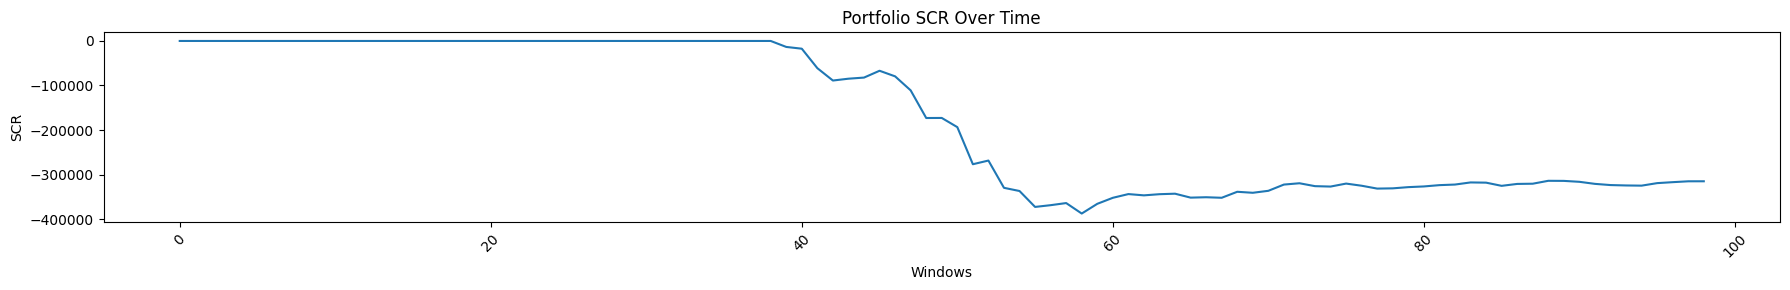

In [27]:
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

'''
plt.figure(figsize=(18, 3))
plt.plot(test_returns_df.index[:-3], scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()
'''

plt.figure(figsize=(18, 3))
plt.plot(scr_values, linestyle='-')
plt.xlabel("Windows")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

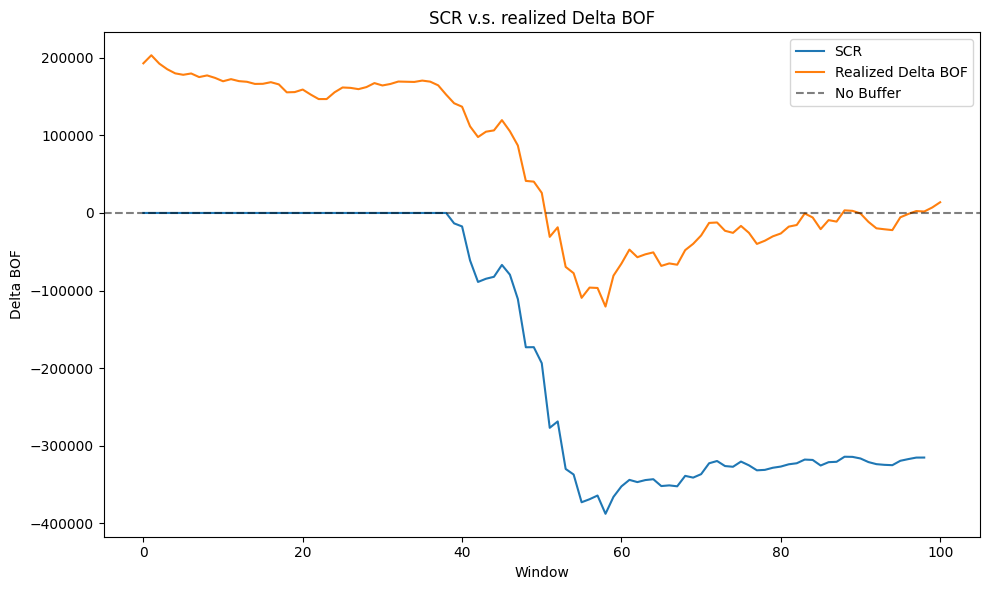

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(scr_values, linestyle='-', label='SCR')
plt.plot(realized_delta_bof_values_1, linestyle='-', label='Realized Delta BOF')

# Add a vertical dashed line - you can change the position as needed
plt.axhline(y=0, color='black', linestyle='--', label='No Buffer', alpha=0.5)

plt.xlabel("Window")
plt.ylabel("Delta BOF")
plt.title("SCR v.s. realized Delta BOF")
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
from backtesting.perform_var_tests import evaluate_risk_metrics

In [30]:
evaluate_risk_metrics(scr_values, realized_delta_bof_values_1)

breaches [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,Metric,Value,Description,Pass/Fail
0,Balanced SCR Loss (α=0.25),58133.2190,Penalty for under-conservatism,
1,Balanced SCR Loss (α=0.5),116266.4380,Penalty for balanced,
2,Balanced SCR Loss (α=0.75),174399.6570,Penalty for capital inefficiency,
3,Kupiec POF Test p-value,0.3191,Tests if breach frequency matches expected,✅
4,Indep. Test p-value,1.0000,Tests if breaches are independent,✅
5,Cond. Coverage p-value,0.6088,Combined test of frequency and independence,✅
6,Lopez Average Loss,0.0000,Quadratic loss function for VaR breaches,
7,Breach Rate,0.0000,Proportion of time when Delta BOF < SCR,
